In [1]:
import numpy as np
import tensorflow as tf
import imutils as imutils
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
from matplotlib import pyplot as plt
import os
import glob
import cv2
import pickle
import joblib
from PIL import Image

## 데이터 준비하기

In [2]:
datas = glob.glob("../dataz/*/*.jpg")

In [3]:
X = []
Y = []
dc = {'False' : 0, 'True' : 1}
for data in datas:
    img = cv2.imread(data)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    X.append(img)
    label = data.split("\\")[1]
    Y.append(dc[label])

In [4]:
X = np.array(X)
Y = np.array(Y)

In [5]:
X.shape

(2723, 224, 224, 3)

In [6]:
trainData, testData, trainLabel, testLabel = train_test_split(X, Y, test_size = 0.2, shuffle=True, random_state = 42)

trainLabel = trainLabel[..., tf.newaxis]
testLabel = testLabel[..., tf.newaxis]

In [7]:
trainData.shape, trainLabel.shape, testData.shape, testLabel.shape
numTrain  = trainData.shape[0]
numTest = testData.shape[0]

In [11]:
unique, counts = np.unique(np.reshape(trainLabel, (numTrain, )), axis = -1, return_counts = True)
for i in range(2):
    print(f"Label {unique[i]} : {counts[i]}")

Label 0 : 1067
Label 1 : 1111


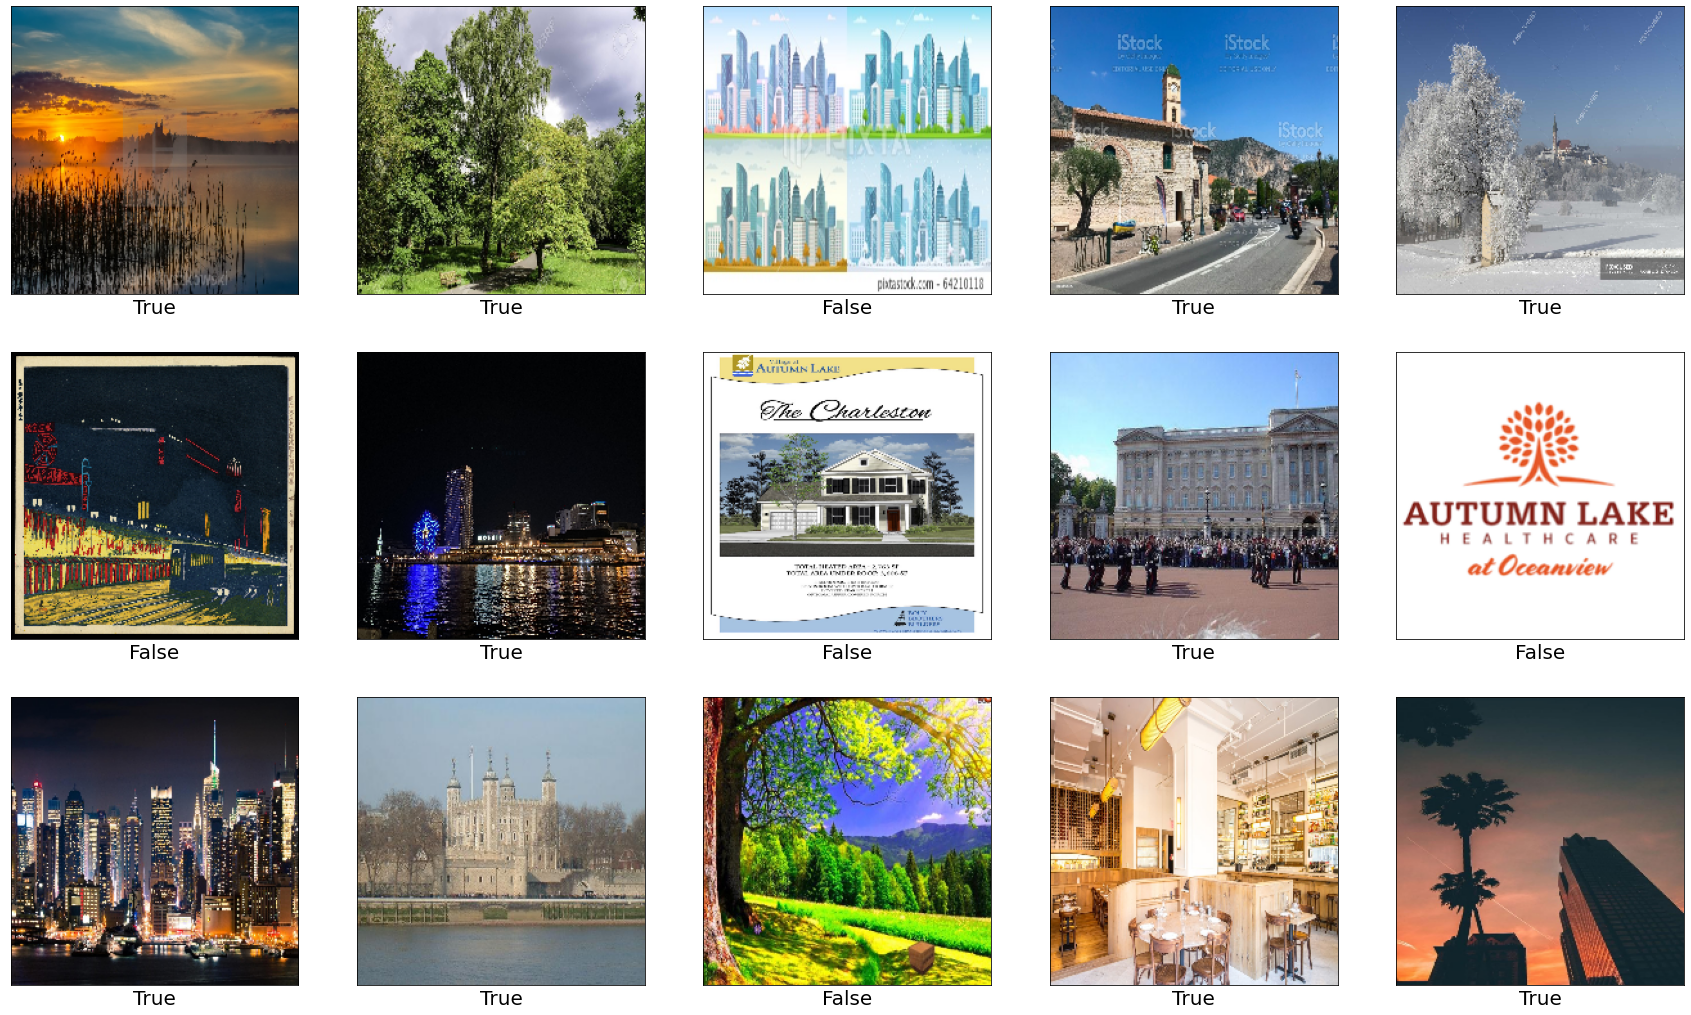

In [14]:
plt.figure(figsize = (30, 18))
for i in range(15):
    img_idx = np.random.randint(0, numTrain)
    plt.subplot(3,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainData[img_idx])
    plt.xlabel("True" if trainLabel[img_idx] else "False", fontsize=20)

In [15]:
# 모든 픽셀을 255.으로 나눠줍니다.
trainData = trainData.astype(np.float32) / 255.
testData = testData.astype(np.float32) / 255.

In [16]:
#Set Hyperparameter
lr = 0.01
EPOCHS = 40
IMG_SIZE =(224, 224)
BATCH = 100
CLASS = 2
steps_per_epoch = numTrain//BATCH
validation_steps = numTest//BATCH

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainData, trainLabel)).shuffle(buffer_size=numTrain).batch(BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel)).batch(BATCH)

## 학습 모델 만들기

### xception model transfer learning

In [25]:
base_model = tf.keras.applications.xception.Xception(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

In [26]:
base_model.trainable = False

In [27]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129 

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5
)

model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(train_dataset, epochs = EPOCHS, steps_per_epoch = steps_per_epoch, validation_data = test_dataset, validation_steps = validation_steps, callbacks=[early_stopping])

Epoch 1/40
21/21 [==============================] - 13s 495ms/step - loss: 2743.4287 - accuracy: 0.5057 - val_loss: 3.2987 - val_accuracy: 0.4840
Epoch 2/40
21/21 [==============================] - 10s 486ms/step - loss: 1.1696 - accuracy: 0.5168 - val_loss: 0.7413 - val_accuracy: 0.4840
Epoch 3/40
21/21 [==============================] - 10s 481ms/step - loss: 0.5940 - accuracy: 0.5072 - val_loss: 1.0795 - val_accuracy: 0.4840
Epoch 4/40
21/21 [==============================] - 10s 484ms/step - loss: 0.8135 - accuracy: 0.5115 - val_loss: 0.9517 - val_accuracy: 0.4840
Epoch 5/40
21/21 [==============================] - 10s 484ms/step - loss: 1.0327 - accuracy: 0.5034 - val_loss: 0.6872 - val_accuracy: 0.4840
Epoch 6/40
21/21 [==============================] - 10s 484ms/step - loss: 0.4760 - accuracy: 0.5091 - val_loss: 0.9811 - val_accuracy: 0.4840


### VGG16 model transfer learning

In [30]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


C:\Users\khyog\anaconda3\envs\lab\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5
)

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

C:\Users\khyog\anaconda3\envs\lab\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
21/21 [==============================] - 25s 542ms/step - loss: 3.3336 - accuracy: 0.6895 - val_loss: 1.3711 - val_accuracy: 0.8380
Epoch 2/40
21/21 [==============================] - 21s 555ms/step - loss: 0.8390 - accuracy: 0.8816 - val_loss: 0.6432 - val_accuracy: 0.8840
Epoch 3/40
21/21 [==============================] - 11s 551ms/step - loss: 0.3567 - accuracy: 0.9158 - val_loss: 0.5132 - val_accuracy: 0.8860
Epoch 4/40
21/21 [==============================] - 11s 551ms/step - loss: 0.1715 - accuracy: 0.9504 - val_loss: 0.3899 - val_accuracy: 0.9200
Epoch 5/40
21/21 [==============================] - 11s 553ms/step - loss: 0.0991 - accuracy: 0.9625 - val_loss: 0.3696 - val_accuracy: 0.9300
Epoch 6/40
21/21 [==============================] - 12s 561ms/step - loss: 0.0534 - accuracy: 0.9803 - val_loss: 0.3443 - val_accuracy: 0.9040
Epoch 7/40
21/21 [==============================] - 12s 556ms/step - loss: 0.0598 - accuracy: 0.9745 - val_loss: 0.3530 - val_accuracy: 0.9040

In [196]:
# save model
model.save("model.h5")

 ## Evaluate

In [33]:
IMG_SIZE =(224, 224)
def preprocess_imgs(path, img_size):
    set_new = []
    for img in os.listdir(path):
        img = cv2.imread(path + "/" + img)
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(tf.keras.applications.vgg16.preprocess_input(img))
    
    return np.array(set_new)

Test_Path = '../tmp'
test_data = preprocess_imgs(Test_Path, img_size=IMG_SIZE)
reality = [1] * 1038

# for img in os.listdir(Test_Path):
#     reality.append(1) if value.lower() == "hemmorhage_data" else reality.append(0)
        
predictions = model.predict(test_data)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(reality, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9065510597302505
